In [1]:
import pandas as pd
import numpy as np
from data_utils import load_pulse, build_pulse, basic_processing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [35]:
# Periods: https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html
df = build_pulse(18, 45)

Opening local file for pulse week18
Opening local file for pulse week19
Opening local file for pulse week20
Opening local file for pulse week21
Opening local file for pulse week22
Opening local file for pulse week23
Opening local file for pulse week24
Opening local file for pulse week25
Opening local file for pulse week26
Opening local file for pulse week27
Opening local file for pulse week28
Opening local file for pulse week29
Opening local file for pulse week30
Opening local file for pulse week31
Opening local file for pulse week32
Opening local file for pulse week33
Opening local file for pulse week34
Opening local file for pulse week35
Opening local file for pulse week36
Opening local file for pulse week37
Opening local file for pulse week38
Opening local file for pulse week39
Opening local file for pulse week40
Opening local file for pulse week41
Opening local file for pulse week42
Opening local file for pulse week43
Opening local file for pulse week44
Week:  45
Retrieving url:  h

In [36]:
print("Shape before:", df.shape)
# df = df[~df["DOWN"].isin([-99, -88])]
# df = df[~df["ANXIOUS"].isin([-99, -88])]
df = df[~df["INCOME"].isin([-99, -88])]
df = df[~df["THHLD_NUMKID"].isin([-99, -88])]
print("Shape after:", df.shape)

Shape before: (1961696, 423)
Shape after: (1519840, 423)


In [37]:
print("Shape before:", df.shape)
df = df[df['TBIRTH_YEAR'] < 2003]
print("Shape after:", df.shape)

Shape before: (1519840, 423)
Shape after: (1518418, 423)


In [38]:
print("Shape before:", df.shape)
df = df[df['ABIRTH_YEAR'] == 2]
print("Shape after:", df.shape)

Shape before: (1518418, 423)
Shape after: (1513607, 423)


In [39]:
print("Shape before:", df.shape)
df = df[df['AHHLD_NUMKID'] == 2]
print("Shape after:", df.shape)

Shape before: (1513607, 423)
Shape after: (1492226, 423)


In [40]:
print("Shape before:", df.shape)
# df = df[df['INCOME'] < 5]
print("Shape after:", df.shape)

Shape before: (1492226, 423)
Shape after: (1492226, 423)


In [41]:
df = basic_processing(df)

In [142]:
df[(df["CTC_Eligible"] == 1) & (df['POST'] == 1)]["Received_CTC"].value_counts(normalize=True)

1    0.661219
0    0.338781
Name: Received_CTC, dtype: float64

1) Less than $25,000  
2) $25,000 - $34,999  
3) $35,000 - $49,999   
4) $50,000 - $74,999   
5) $75,000 - $99,999   
6) $100,000 - $149,999   
7) $150,000 - $199,999
8) $200,000 and above 

In [167]:
df_m = df.query("INCOME < 6")

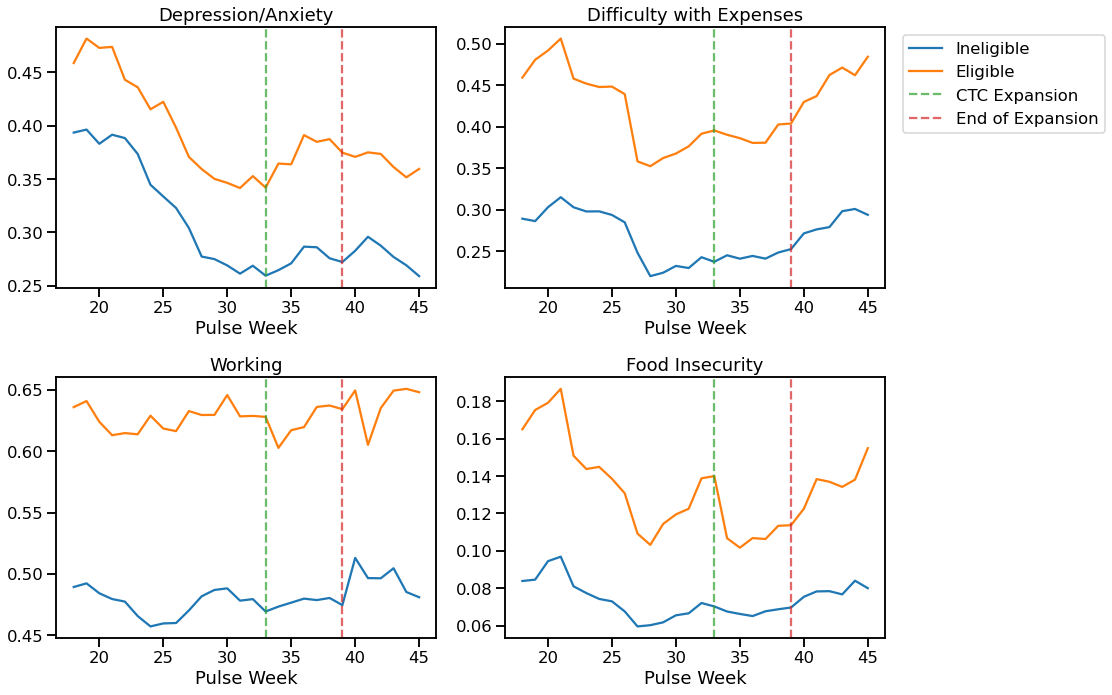

In [144]:
sns.set_context("talk")
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
dependent_vars = ['SYMPTOMATIC', 'Difficulty_w_Expenses', 'WORKING', 'Food_Insecurity']
titles = ['Depression/Anxiety', 'Difficulty with Expenses', 'Working', 'Food Insecurity']
counter = 0
for i in range(2):
    for j in range(2):
        df_m.pivot_table(columns="CTC_Eligible", index="WEEK", values=dependent_vars[counter]).plot(ax=ax[i, j], legend=False)
        ax[i, j].axvline(33, c='tab:green', linestyle="--", alpha=.7)
        ax[i, j].axvline(39, c='tab:red', linestyle="--", alpha=.7)
        ax[i, j].set_title(titles[counter])
        ax[i, j].set_xlabel("Pulse Week")
        counter += 1
ax[0, 1].legend(["Ineligible", "Eligible", "CTC Expansion", "End of Expansion"], loc="upper right", bbox_to_anchor=(1.6, 1))
fig.tight_layout();

In [168]:
dependent = 'Food_Insecurity'
control_list = ["SNAP", "Received_Free_Food", "Received_EBT", "Age", "Age**2", "INCOME", "EEDUC"]
controls = " + ".join(control_list)
controls

'SNAP + Received_Free_Food + Received_EBT + Age + Age**2 + INCOME + EEDUC'

In [169]:
dids = []
for var in dependent_vars:
    formula = f"{var} ~  CTC_Eligible + POST + {controls} + TREAT"
    basic_did = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['HWEIGHT']
        ).fit(cov_type="HC1"))
    dids.append(basic_did)



In [178]:
with open("models/did_models.p", "wb") as f:
    pickle.dump(dids, f)

In [170]:
summary_col([*dids], stars=True)

,SYMPTOMATIC,Difficulty_w_Expenses,WORKING,Food_Insecurity
Intercept,0.7173***,0.7039***,0.9358***,0.4217***
,(0.0104),(0.0106),(0.0103),(0.0094)
INCOME[T.2],-0.0487***,-0.0738***,0.1251***,-0.0721***
,(0.0034),(0.0034),(0.0033),(0.0030)
INCOME[T.3],-0.0741***,-0.1378***,0.1696***,-0.1088***
,(0.0033),(0.0033),(0.0032),(0.0027)
INCOME[T.4],-0.1072***,-0.2185***,0.2139***,-0.1467***
,(0.0030),(0.0030),(0.0029),(0.0024)
INCOME[T.5],-0.1426***,-0.2844***,0.2499***,-0.1708***
,(0.0031),(0.0030),(0.0030),(0.0024)


In [171]:
summary_col([*dids], stars=True, regressor_order=["TREAT"], drop_omitted=True)

,SYMPTOMATIC,Difficulty_w_Expenses,WORKING,Food_Insecurity
TREAT,0.0308***,-0.0075,-0.0034,-0.0254***
,(0.0052),(0.0051),(0.0051),(0.0039)
R-squared,0.0785,0.1506,0.2319,0.1005
R-squared Adj.,0.0785,0.1506,0.2319,0.1005


In [172]:
fe_dids = []
for var in dependent_vars:
    formula = f"{var} ~  CTC_Eligible + C(WEEK) + {controls} + TREAT"
    fixed_effects_did = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['HWEIGHT']
            ).fit(cov_type="HC1"))
    fe_dids.append(fixed_effects_did.summary())


In [177]:
with open("models/fe_models.p", "wb") as f:
    pickle.dump(fe_dids, f)

In [173]:
summary_col([*fe_dids], stars=True, regressor_order=["TREAT"], drop_omitted=True)

,SYMPTOMATIC,Difficulty_w_Expenses,WORKING,Food_Insecurity
TREAT,0.0269***,-0.0086*,-0.0028,-0.0261***
,(0.0052),(0.0051),(0.0051),(0.0039)
R-squared,0.0859,0.1551,0.2326,0.1022
R-squared Adj.,0.0859,0.1551,0.2326,0.1022


In [174]:
event_studies = []
for var in dependent_vars:
    formula = f"{var} ~ C(EST_ST) +  {controls} + C(WEEK)*CTC_Eligible"
    event_study = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['HWEIGHT']
            ).fit(cov_type='HC1'))
    event_studies.append(fixed_effects_did)

In [175]:
import pickle

In [176]:
with open("models/event_studies.p", "wb") as f:
    pickle.dump(event_studies, f)

In [67]:
estimates = pd.DataFrame({"coef": event_study.params, "std_err":event_study.HC1_se, "low": event_study.conf_int()[0], "high": event_study.conf_int()[1]})

In [68]:
estimates = estimates.reset_index().rename({"index": "name"}, axis=1)

In [69]:
did_estimates = estimates[estimates['name'].str.startswith('C(WEEK)[T.') & estimates['name'].str.endswith('CTC_Eligible')]

In [70]:
did_estimates = did_estimates.reset_index(drop=True)

In [71]:
did_estimates['week'] = range(df['WEEK'].min()+1, df['WEEK'].max()+1)

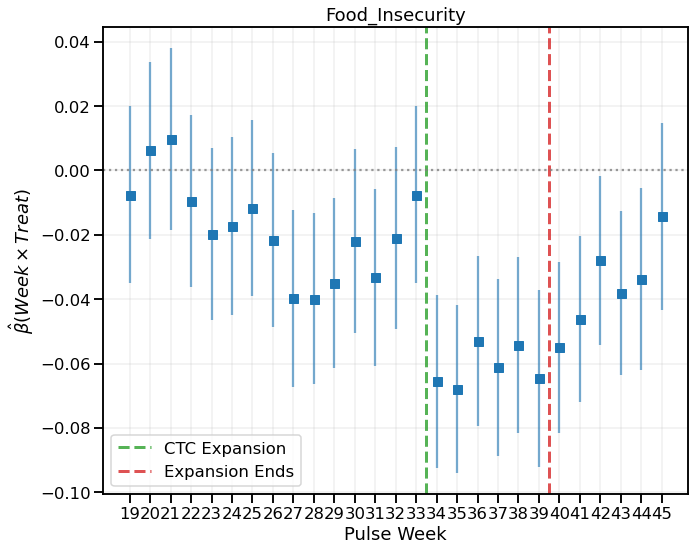

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.axvline(14.5, c="tab:green", alpha=.8, linestyle="--", linewidth=3, label="CTC Expansion")
ax.axvline(20.5, c="tab:red", alpha=.8, linestyle="--", linewidth=3, label="Expansion Ends")
ax.errorbar(did_estimates.index, did_estimates['coef'], yerr=did_estimates['high']-did_estimates['coef'], alpha=.6, c="tab:blue", fmt='none')
ax.plot(did_estimates['coef'], "s")
# ax.plot(did_estimates['low'], "s", c="tab:blue")
# ax.plot(did_estimates['high'], "s", c="tab:blue")
ax.axhline(0, c="grey", alpha=.8, linestyle=":")
ax.grid(alpha=.2)
ax.legend(loc="lower left")

ax.set_xlabel("Pulse Week")
ax.set_ylabel(r"$\hat{\beta} (Week \times Treat)$")
ax.set_title(f"{dependent}")

ax.set_xticks(did_estimates.index, did_estimates['week'])

fig.tight_layout()